# Image Interpretation – Assignment 3

This assignment on Regression covers the labs from 25th October and 1st of November. The exercises on this sheet are graded by a maximum of 10 points. You will be asked to implement several functions and write a brief report.

In order to submit the results, send this ipynb file which should contain implemented functions and brief reports with all findings to <mikhail.usvyatsov@geod.baug.ethz.ch> with subject
[Image Interpretation 2018 Assignment 3]
no later than on the
7th of November, 2018.

Your functions should work when called by the provided test code (functions prefixed with `test` ) which must not be modified. When run, they should produce a plausible output, no warnings, and no unnecessary output. Eventual example output is given in the ref_-images. The functions that you write take images as arguments, not image filenames (i.e. do not use imread inside the functions). Your functions should not generate figures/plots themselves, the plots are generated by the test functions.

In addition to the functions, include a brief report explaining the structure of the code and the Python functions used. This includes the reasons for choosing particular functions as well as a short justification of their parameter setting. For the more complicated tasks, the choice of the underlying data structures and algorithms should be explained too. We encourage you to add also diagrams, illustrations, and figures into the report when appropriate, but it is not necessary to copy the related theory from the lecture slides. The code should contain comments if appropriate.

**Team work is not allowed**. Everybody implements his/her own code and writes his/her own report. Discussing issues with others is fine, sharing code and/or report with others is **not**. If you use any code fragments found on the Internet, make sure you reference them properly.

This exercise focuses on using classification methods, as
implementing most classifiers takes more time than is reasonable in the scope of
this assignment. The exception is the exercise about LDA, which is
simple enough to be done manually. The rest of the programming exercises are very
short.

As in the regression assignment, $Y$ stands for a column vector of "_target_" values, that is the $i$-th row of $Y$ contains the desired output for the $i$-th
data point. Contrary to regression, the elements of $Y$ are integer values. In
most exercises we use binary classifiers, where one class has the label $1$ and
the other class has the label $2$. 
$X$ is a matrix containing the feature values, where the $i$-th row contains
the values for the $i$-th data point.

The synthetic data are generated randomly for each run in the
"_toy example_" test functions, so you can run the functions multiple times to get
different outputs.

In your reports, comment on the performance of the individual
methods when applied on the aerial photo of Graz. Describe also the difference
between the results on data seen during training (the left quarter of the image) and
data that are "_new_" (the rest of the image). Does a given method work equally
well for every class?
You can (and actually need to in order to generate the results for the report)
change the "_true_" class in the test functions that use binary
classification by changing the __true_class__ variable if you want to see
outputs for different classes. A value of $1$ represents streets, $2$ buildings, and
$3$ vegetation. A reference to this is given in function `untitled`.

You can also use more
features for classification (features from a lower scale) by employing function
ii_gaussian which you implemented in the second exercise (see the commented
lines with __create_features__ in the test functions).

In [1]:
def untitled():
    X_1 = X[Y == 1, :]

    # You can edit the test scripts if you 
    # want to see results for different classes 
    # change true_class value to
    # 1: streets
    # 2: buildings
    # 3: vegetation
    # You can also see test_lda2 to see how 
    # to use more features

# Problem 1, 1p

Nearest neighbour classification (especially its k-NN variant) is a simple
but yet quite powerful classification method which does not make any 
assumptions about the data model.

[Scikit-learn](http://scikit-learn.org/stable/) class http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html performing k-NN classification is demonstrated
in functions `demo_knn` (toy example) and `demo_knn2` (Graz aerial
photo). In the toy example, one can see the classification of red and blue points
into red and blue classes, respectively. Graz aerial photo example and the class
values for the second test have been explained in the introduction already.

Run the functions for different values of parameter $K$, $distance$ and $rule$ and comment the
results in your report. Also report the best parameters with explanation
why you think that they are the best.

In [2]:
import sklearn as sk
import sklearn.metrics 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import cv2

%matplotlib inline

In [3]:
def synthetic_nonlin():
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        
        return x, y

    n_samples = 100
    X_1 = np.random.randn(n_samples, 2) / 2
    
    a, b = pol2cart(np.random.rand(n_samples, 1) * 2 * np.pi, np.random.randn(n_samples, 1) / 3 + 1.5)
    X_2 = np.hstack([a, b])
    X = np.concatenate([X_1, X_2], axis=0)
    Y = np.concatenate([np.ones((n_samples)), 2 * np.ones((n_samples))]) - 1
    
    return X, Y

def decision_boundaries_vec(x_range, steps, classifier):
    l = np.linspace(x_range[0], x_range[1], steps)
    x, y = np.meshgrid(l, l)
    
    features = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=-1)
    
    if hasattr(classifier, 'predict'):
        return x, y, classifier.predict(features).reshape(x.shape)
    else:
        return x, y, classifier(features).reshape(x.shape)


def demo_knn():
    X, Y = synthetic_nonlin()
    
    classifier = KNeighborsClassifier(n_neighbors = 5)
    classifier.fit(X, Y)

    x_range = np.array([X.min(), X.max()])

    x, y, decision_boundaries = decision_boundaries_vec(x_range, 1000, classifier)

    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, decision_boundaries)
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c='r', marker='*')
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c='b', marker='o')
    plt.title('KNN (K=5)')


def load_graz(scale):
    img = cv2.imread('../data/graz_5.tif')
    gt = cv2.imread('../data/gt_graz_5.tif', 0)

    gt[gt == 4] = 3
    new_scale = tuple((np.array(img.shape) * scale).astype(np.int64))[:-1]
    
    return cv2.resize(img, new_scale), cv2.resize(gt, new_scale)


def create_features(varargin):
    sy, sx, nc = varargin.shape
    return varargin.reshape(sy * sx, nc)

def demo_knn2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 2

    Y = (gt == true_class) + 1

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
    axs[0].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[0].set_title("Original")
    
    classifier = KNeighborsClassifier(n_neighbors=7,weights='distance')
    classifier.fit(X, Y)
    results_test = classifier.predict(X[used_train:sy * sx, :])
    results = np.concatenate([Y[:used_train], results_test]).reshape(sy, sx)
    axs[1].imshow(results, cmap=plt.cm.gray)
    axs[1].set_title("n_neighbors=7, weights='distance'")
    print("accuracy of neighbors=7 & weight by distance :", sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))
    
    n_neighbors = np.arange(1,17,3)
    
    for i in range(len(n_neighbors)):
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors[i])
        classifier.fit(X, Y)
        results_test = classifier.predict(X[used_train:sy * sx, :])
        results = np.concatenate([Y[:used_train], results_test]).reshape(sy, sx)
        print("accuracy of neighbors=%d :" % n_neighbors[i],sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))
        
    for i in range(len(n_neighbors)):
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors[i],weights='distance')
        classifier.fit(X, Y)
        results_test = classifier.predict(X[used_train:sy * sx, :])
        results = np.concatenate([Y[:used_train], results_test]).reshape(sy, sx)
        print("accuracy of neighbors=%d & weight by distance:" % n_neighbors[i],sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))

    classifier = KNeighborsClassifier(n_neighbors=7,weights='distance',p = 1)
    classifier.fit(X, Y)
    results_test = classifier.predict(X[used_train:sy * sx, :])
    results = np.concatenate([Y[:used_train], results_test]).reshape(sy, sx)
    print("accuracy of neighbors=7 & weight by distance & manhattan_distance:" ,sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))

    classifier = KNeighborsClassifier(n_neighbors=7,weights='distance',p = 3)
    classifier.fit(X, Y)
    results_test = classifier.predict(X[used_train:sy * sx, :])
    results = np.concatenate([Y[:used_train], results_test]).reshape(sy, sx)
    print("accuracy of neighbors=7 & weight by distance & minkowski_distance:" ,sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))


accuracy of neighbors=7 & weight by distance : 0.94406
accuracy of neighbors=1 : 0.928588
accuracy of neighbors=4 : 0.921528
accuracy of neighbors=7 : 0.9216
accuracy of neighbors=10 : 0.919504
accuracy of neighbors=13 : 0.918684
accuracy of neighbors=16 : 0.91742
accuracy of neighbors=1 & weight by distance: 0.928588
accuracy of neighbors=4 & weight by distance: 0.9414
accuracy of neighbors=7 & weight by distance: 0.94406
accuracy of neighbors=10 & weight by distance: 0.944672
accuracy of neighbors=13 & weight by distance: 0.945036
accuracy of neighbors=16 & weight by distance: 0.945056
accuracy of neighbors=7 & weight by distance & manhattan_distance: 0.94406
accuracy of neighbors=7 & weight by distance & minkowski_distance: 0.94406


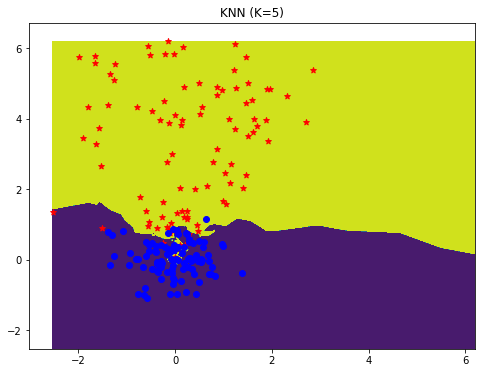

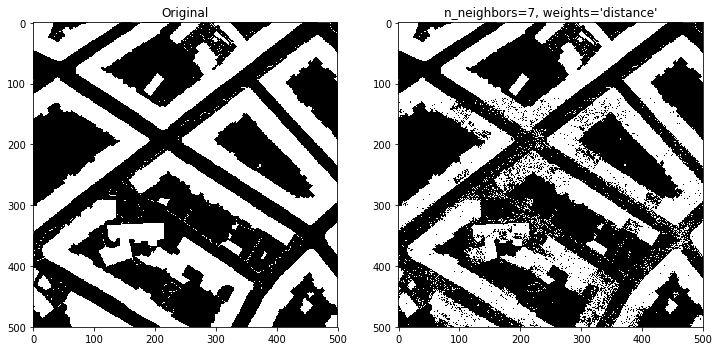

In [4]:
demo_knn()
demo_knn2()

# Brief Report
From the function `demo_knn()`, we can see that as the `n_neighbors` parameter rises, the classified category boundaries become smoother. The parameter `weights` can weight points by the inverse of their distance, which is better to describe data with spatial properties. While the parameter `p` is able to adjust the distance calculation method, where `euclidean_distance` is the most commonly used distance measurement method.

I tested the different accuracy given different input parameters. From the result of `true_class = 2`, we can see that when performing KNeighborsClassifier using `uniform` weights, the accuracy decreases with the rising of `n_neighbors` and the highest accuracy is observed when `n_neighbors = 1`. However, if we weight points by the inverse of their distance, higher accuracies could be obtained. The accuracy will gradually stabilize at around 0.944. The choice of distance measuring would not influence the accuracy in this particular task.

Similar trends are observed when `true_class = 1` and `true_class = 3`. However, the accuracy of class 3 is obviously higher than the other two classes. When `n_neighbors > 7` and `weights='distance'`, accuracy for class 1 = 0.944868, accuracy for class 2 = 0.94406, accuracy for class 3 = 0.98922.

After testing, the best-chosen parameters should be: `n_neighbors > 7` and not too big, which could result in low computational efficiency; `weights='distance'`; and `p` optional.

# Problem 2, 4p

LDA classifier can be used to efficiently classify linearly separable data.
Implement function `ii_train_lda` that trains an LDA classifier. The
input arguments are the training data (one row per sample and one column per
feature) and a column vector with the class labels of the samples (0
or 1). Return the normal $\theta$ of the decision boundary and the threshold
$t$ between classes (so that if $X\theta - t > 0$, class $1$ is predicted).
Since we use row vectors as features, the formulas are slightly different
from those seen in the lecture (but $\theta$ is still a column vector).

$m_1$ and $m_2$ are the means of the input features over all rows
where $Y$ is $0$ or $1$ respectively. You can calculate mean and covariance
for the classes with corresponding __numpy__ methods.
In order to do operations on the rows of $X$ where the corresponding row in $Y$
has a certain value (e.g.\ $1$), you can use the expression `X[Y==1,:]`.
Instead of determining $\theta$ by matrix inversion, which is numerically
unstable, use __numpy/scipy__ equation solving capabilities:


`normal = np.linalg.lstsq(SW, (m2-m1).T)[0]`


where SW is the sum of within-class covariances.
The threshold you output is the value of the projection at the point located
in the middle between the class means (the (dot) product of the mean of
$m_1$ and $m_2$ and the estimated normal).

The corresponding `test_lda` is already provided. You can use
functions `test_lda` and `test_lda2` to test your implementation and generate
results for the report.

In [5]:
def rotate_base(mat, ang):
    R = np.array([
        [np.cos(ang), np.sin(ang)],
        [-np.sin(ang), np.cos(ang)]
    ])
    
    return R.T.dot(mat).dot(R)


def mvarnormal(numelements, Sigma, mu):
    R = np.linalg.cholesky(Sigma)
    data = np.tile(mu, (numelements, 1))
    data = data + np.random.randn(numelements, len(mu)).dot(R)
    return data


def two_gaussians(samples_per_gaussian, m1, m2, S1, S2):
    Y = np.ones((samples_per_gaussian * 2))
    Y[-samples_per_gaussian:] = 0
    X = np.concatenate([mvarnormal(samples_per_gaussian, S1, m1), mvarnormal(samples_per_gaussian, S2, m2)])
    
    return X, Y


def synthetic_lin():
    S = np.array([[10, 0],
                  [0, 5]])
    X, Y = two_gaussians(50, [-4, 0], [4, 0], rotate_base(S, np.pi / 4), rotate_base(S, np.pi / 3))
    return X, Y

In [6]:
from itertools import combinations as comb

def del_first_col(x):
    return x[:, 1:].copy()

def x2fx(x, model='linear'):
    linear = np.c_[np.ones(x.shape[0]), x]
    if model == 'linear':
        return linear
    if model == 'purequadratic':
        return np.c_[linear, x**2]
    interaction = np.hstack([x[:,i]*x[:,j] for i, j in
                                 comb(range(x.shape[1]), 2)]).T
    if model == 'interaction':
        return np.c_[linear, interaction]
    if model == 'quadratic':
        return np.c_[linear, interaction, x**2]

def test_lda():
    x_range = [-10, 10]

    X, Y = synthetic_lin()

    normal, threshold = ii_train_lda(X, Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_lda(x, normal, threshold)
    )

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4,4))
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('LDA')

    x_range = [-2.5, 7.5]
    X, Y = synthetic_nonlin()

    normal, threshold = ii_train_lda(del_first_col(x2fx(X, 'quadratic')), Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_lda(del_first_col(x2fx(x, 'quadratic')), normal, threshold)
    )
    
    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('LDA (lifted)')


def test_lda2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = gt == true_class

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    normal, threshold = ii_train_lda(X[:used_train, :], Y[:used_train])

    results = ii_test_lda(X, normal, threshold)

    results = results.reshape(sy, sx)

    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')
    
    print("Accuracy of aerial photo of Graz:",sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))


In [7]:
def ii_train_lda(train_X, train_Y):
#      calculate mean for each classes 
    train_X0 = train_X[train_Y==0,:]
    train_X1 = train_X[train_Y==1,:]
    m1 = train_X0.mean(0)
    m2 = train_X1.mean(0) 
#     Sum of within-class covariance matrices
    Sw = (train_X0-m1).T.dot(train_X0-m1) + (train_X1-m2).T.dot(train_X1-m2)
#     solve
    normal = np.linalg.lstsq(Sw, (m2-m1).T, rcond=None)[0]
#     get the threshold
    threshold = normal.dot((m2+m1)/2)

    return normal,threshold

def ii_test_lda(x, normal, threshold):
#     ini predicted_Y
    predicted_Y = np.ones(x.shape[0])
     
#     calculate the results of the given X data
    result = x.dot(normal) - threshold

#     split into two classes
    predicted_Y[ result > 0 ] = 1
    predicted_Y[ result <=0 ] = 0
    
    return predicted_Y

Accuracy of aerial photo of Graz: 0.965392


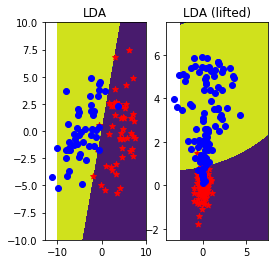

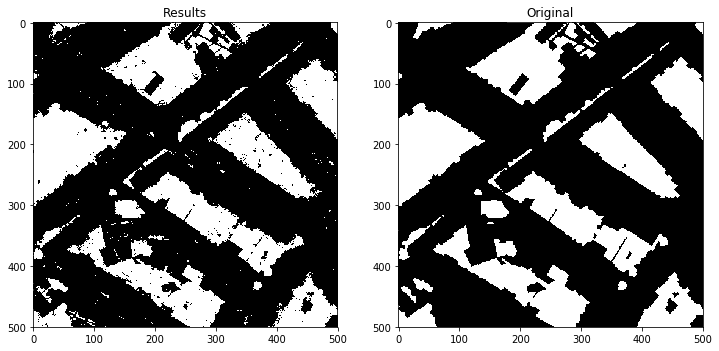

In [8]:
test_lda()
test_lda2()

# Brief Report
As for the aerial photo of Graz classification, the accuracy for class 1 = 0.740052, accuracy for class 2 = 0.84952, accuracy for class 3 = 0.965392. The LDA obviously does not work equally well for every class. 

Also, the classification performance of LDA is not as good as KNN. However, KNN does not scale well, meaning that when increasing the number of neigbourhoods or data amount, the computational effort will increase.

# Problem 3, 3 points
Logistic regression is a probabilistically principled classification method.
You are provided with the breast cancer dataset. You task is to implement function `ii_train_logress`
that uses __sciki-learn__ class `sklearn.linear_model.LogisticRegression` to fit a logistic regression model to the data. It should take
the same input arguments as train_lda and return the trained model. Also implement function `ii_test_logress`
that takes the trained model and input
features (in the common format) and returns the output of the logistic
regression model. Make sure you cget through the documentation for [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

You can use functions `test_logress` and `test_logress2` to test your
implementation.

Implement the function `classify_breast_cancer_with_logress` which using the functions `ii_train_logress` and
`ii_test_logress` can distinguish benign and malignant tumor. Use 75% of the dataset for training.

Note, that there are missing values in the dataset. You have to either:
* remove such examples
* interpolate missing values

in order to let python load the data for you with `pandas.read_csv('data/data.csv')`.

You can find description of the dataset in file _description.txt_.
Report how well logistic regression works for the breast cancer prediction (accuracy).

In [9]:
def test_logres():
    x_range = [-10, 10]
    X, Y = synthetic_lin()
    Y = Y * 2 - 1
    
    model = ii_train_logress(X, Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: (ii_test_logress(model, x) > 0.5) * 2 - 1
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('Logistic Regression') 

    x_range = [-2.5, 5]

    X, Y = synthetic_nonlin()
    Y = Y * 2 - 1

    model = ii_train_logress(del_first_col(x2fx(X,'quadratic')), Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000,
        lambda x: 1 + (0.5 < ii_test_logress(model, del_first_col(x2fx(x, 'quadratic'))))
    )

    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('Logistic Regression (lifted)') 


def test_logres2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = (gt==true_class) * 2 - 1

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx, 1)

    model  = ii_train_logress(X[:used_train, :], Y[:used_train, :])
    results = ii_test_logress(model, X)
    results = results.reshape(sy, sx) > 0.5
    
    print("Accuracy of aerial photo of Graz:", model.score(X,Y))

    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas

def ii_train_logress(train_X,train_Y):
#     reshape the train Y into a 1d array
    train_Y = train_Y.reshape(train_Y.size)
#     construct the classifier and fit the data
    clf = LogisticRegression(penalty='l2', solver= 'newton-cg', multi_class = 'auto' ).fit(train_X, train_Y)
#     return the model
    return clf 

def ii_test_logress(model, x):
#     predict class Y with the given model and features
    predicted_Y = model.predict(x)
    
    return predicted_Y 

def classify_breast_cancer_with_logress():
#     read the data
    data = pandas.read_csv('../data/data.csv')
    data = np.array(data)
#     split X and Y
    X = data[:,1:9]
    Y = data[:,10]
#     convert the Benign=2 to -1, Malignant=4 to 1
    Y[Y == 2] = -1
    Y[Y == 4] = 1
    
#     run the classifier several times and calculate the average accuracy 
    accuracies = []
    for i in range(20):
#         train_test_split, with test size 25%, train size 75%
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
#         train 
        model = ii_train_logress(X_train,Y_train)
    
        accuracies.append(model.score(X_test,Y_test))
        
#     Y_predict = ii_test_logress(model,X_test)
    print("Mean accuracy of breast cancer:", np.mean(accuracies))


Accuracy of aerial photo of Graz: 0.968224
Mean accuracy of breast cancer: 0.9695906432748537


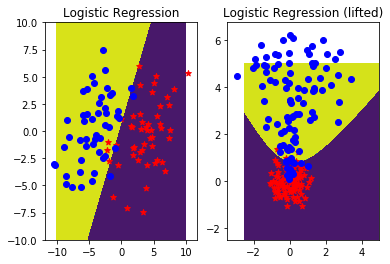

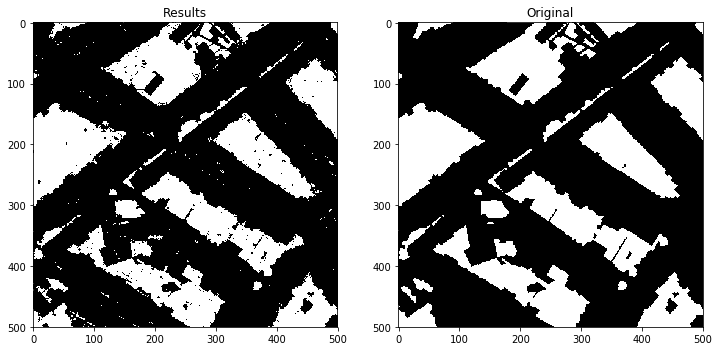

In [11]:
test_logres()
test_logres2()
classify_breast_cancer_with_logress()

# Brief Report
As for the aerial photo of Graz classification, accuracy for class 1 = 0.799116, accuracy for class 2 = 0.853248, accuracy for class 3 = 0.968224. The Logistic regression does not work equally well for every class, but it outperformed the LDA method for every class.

The mean accuracy of classifying breast cancer dataset with logistic regression after 20 times is 0.9628. From the data I got I did not find any missing values in the dataset; therefore, I skip the preprocessing step and directly used the original dataset. As the logistic regression method requires the input class as __-1__ and __1__, I relabeled the input data. By utilizing the train_test_split from sklearn.model_selection, the function can split the whole dataset into training and testing part. Last, the accuracy of the trained model is tested with the testing data. I repeated the process 20 times.


# Problem 4, 2 Points

Classification using random trees and forests is currently very popular
thanks to its efficiency and flexibility.
Implement function `ii_train_tree` that uses sklearn to train a decision tree. The function should use the same
input arguments as the previous training functions, but note that the tree
classifier can handle more than two classes, so this time the input is not
constrained to -1 or 1 (you do not need to handle this, this is done
automatically by the classifier). The function returns the trained decision
tree. Also implement function `ii_test_tree` that takes the trained
decision tree and input features (in the common format) and returns the
prediction made by the tree (search the documentation of sklearn for details.

You can use functions `test_tree` and `test_tree2` to test your
implementation and generate results for the report.

Implement the function `classify_breast_cancer_with_tree` which using the functions `ii_train_tree` and
`ii_test_tree` can distinguish benign and malignant tumor. Use 75% of the dataset for training.

In [12]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\Hong\\Anaconda3\\Library\\bin\\graphviz'


def test_tree():
    x_range = [-10, 10]

    X, Y = synthetic_lin()
    Y = Y * 2 - 1

    model = ii_train_tree(X, Y)
    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_tree(model, x)
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('Tree') 

    x_range = [-2.5, 2.5]
    X, Y = synthetic_nonlin()
    Y = Y * 2 - 1

    model = ii_train_tree(X,Y)
    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_tree(model, x)
    )

    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('Tree')

    from sklearn.externals.six import StringIO  
    from IPython.display import Image  
    from sklearn.tree import export_graphviz
    import pydotplus
    
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()

    
def test_tree2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 1

    Y = gt

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    tree = ii_train_tree(X[:used_train, :], Y[:used_train])

    results = ii_test_tree(tree, X)

    results = results.reshape(sy, sx)

    print(sklearn.metrics.classification_report(Y, results.reshape(sy*sx)))
    print("Accuracy of aerial photo of Graz:",sklearn.metrics.accuracy_score(Y, results.reshape(sy*sx)))

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

In [13]:
from sklearn.tree import DecisionTreeClassifier

def ii_train_tree(X, Y):
    
#     construct the classifier and fit the data
    clf = DecisionTreeClassifier().fit(X,Y)
    
    return clf

def ii_test_tree(model, x):
#     predict class Y with the given model and features
    prediction = model.predict(x)
    
    return prediction


def classify_breast_cancer_with_tree():
#     read the data
    data = pandas.read_csv('../data/data.csv')
    data = np.array(data)
#     split X and Y
    X = data[:,1:9]
    Y = data[:,10]
    
#     run the classifier several times and calculate the average accuracy 
    accuracies = []
    for i in range(20):
#         train_test_split, with test size 25%, train size 75%
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
#         train 
        model = ii_train_tree(X_train,Y_train)
    
        accuracies.append(model.score(X_test,Y_test))
        
#     Y_predict = ii_test_logress(model,X_test)
    print("Mean accuracy of breast cancer:", np.mean(accuracies))

    

              precision    recall  f1-score   support

           1       0.69      0.80      0.74     59557
           2       0.87      0.81      0.84    113296
           3       0.94      0.92      0.93     77147

   micro avg       0.84      0.84      0.84    250000
   macro avg       0.83      0.84      0.84    250000
weighted avg       0.85      0.84      0.85    250000

Accuracy of aerial photo of Graz: 0.842848
Mean accuracy of breast cancer: 0.9450292397660819


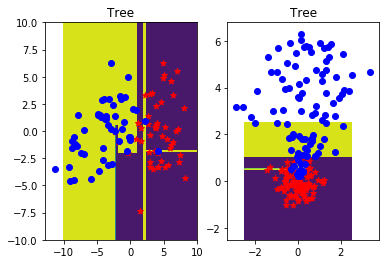

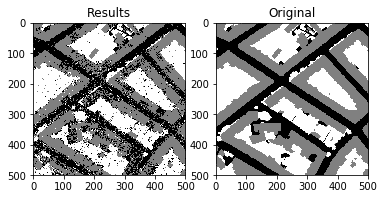

In [14]:
from IPython.display import Image
Image(test_tree())
test_tree2()
classify_breast_cancer_with_tree()

# Brief Report
The mean accuracy for classifying aerial photo of Graz with decision trees is 0.843096. The precision and recall values indicated that the results for class 1 and 2 is still worse than class 3.

The mean accuracy of classifying breast cancer dataset with decision trees after 20 times is 0.9456. The decision tree classifier supports two-class as well as multi-class problem. Again, the accuracy of the trained model is tested with the testing data and I repeated the process 20 times.